# Training a MLP classifier

Sourced from [Pytorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)

Modified by : Harold Mouchère / University of Nantes

Date : 2024

The aim of this exercise is to understand the usage of Multi-Layer Perceptron: training process, meta-parameters and evaluation of the system.

## Q1: Training with a validation dataset

The full dataset is split in 3 parts: training, validation and test.
Thus you can draw the learning curves ie the cost depending of the iteration number.
Try this using two cost values: the error rate and the Mean Squared Error (MSE).
Using this curves, choose the best weight set optimizing the cost on the validation dataset (early stopping).

The first task is to complete the available algorithm with these steps:
1.  train for several mini-batches (not the full train set)
2.  compute the costs on training and validation sets and save the weights if the new model is better than the best
3.  continue the learning until the end of iterations
4.  return with the best neural network
5.  draw the curves
  
[Tips](https://deep.univ-nantes.io/advnn/cours/3_mlp.html#/apprentissage-processus-it%C3%A9ratiftraining-iterative-process-2)

## Q2: Procedural approach

Create a function that does the full training process which takes a network and all other parameters needed for training as inputs.
The function should return the trained network and the learning curves.
Use default values for the parameters to make the function easy to use.

Define also a function that takes the trained network and returns the accuracy of the network on the test set.

## Q3: Count the number of weights

Calculate the number of trainable parameters. Give the detailed calculation in plain text.

## Q4: Overfit MNIST

Modify the number of used training samples, MLP architecture and learning rate to create an overfitting situation.
Draw the curve showing that.

## Preparation of the computer

In [1]:
import time
import copy
import torch
import torchvision
import torchvision.transforms as transforms

print("CUDA available :", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU name :", torch.cuda.get_device_name(0))
    print("GPUs available :", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Using CPU")

CUDA available : True
GPU name : NVIDIA GeForce GTX 1650 Ti
GPUs available : 1


## Preparation of the dataset
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Size of the mini batch:
minibatchsize = 32

# Load the full train set (60K samples)::
datadir = 'data'
fulltrainset = torchvision.datasets.MNIST(root=datadir, train=True, download=True, transform=transform)

# Split the full train part as train and validation (10K samples, some can be ignored):
trainset, validationset, _ignored_part = torch.utils.data.random_split(fulltrainset, [20000, 10000, 30000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatchsize, shuffle=True, num_workers=0)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=minibatchsize, shuffle=False, num_workers=0)

# Load the test set:
testset = torchvision.datasets.MNIST(root=datadir, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatchsize, shuffle=False, num_workers=0)

# Define the set of class names:
classes = range(0,10)
nb_classes = len(classes)

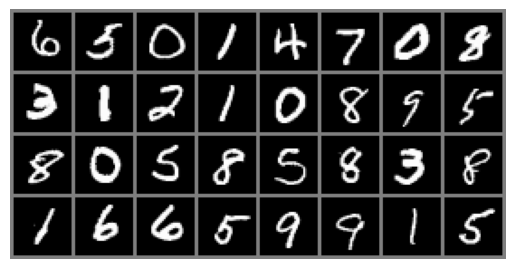

  6   5   0   1   4   7   0   8   3   1   2   1   0   8   9   5   8   0   5   8   5   8   3   8   1   6   6   5   9   9   1   5


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Functions to show an image
def displayDataAsImage(img, filename=''):
    img = img / 2 + 0.5 # Unnormalize
    numpy_img = img.numpy()
    plt.imshow(np.transpose(numpy_img, (1, 2, 0)))
    plt.axis('off')

    if filename == '':
        plt.show()
    else:
        plt.savefig(filename)

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
displayDataAsImage(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%3s' % classes[labels[j]] for j in range(minibatchsize)))

## Define a MLP

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# This class define the architecture
class NetMLP(nn.Module):
    # In the constructor, the useful layers are defined with the correct input/output dimensions
    def __init__(self, hiddencells = 100):
        super(NetMLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 , hiddencells)
        self.fc2 = nn.Linear(hiddencells, 10)
    
    # In the forward function, the layers are applied as functions with the correct order and on a specific data x
    # Dimensions of x are [minibatch size, H, W]
    def forward(self, x):
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [5]:
# Define the network to use :
net = NetMLP(100)
net.to(device) # Move it to GPU or CPU

# Show the structure :
print(net)

NetMLP(
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


## Define a Loss function and the optimizer

In [6]:
import torch.optim as optim

# Let's use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network
This is the core part of the code, implementing the training loops. Answer Q1 with code.

In [7]:

# Definition of arrays to store the results and draw the learning curves
val_err_array = np.array([])
train_err_array = np.array([])
nb_sample_array = np.array([])

# Best system results
best_val_loss = 1000000
best_nb_sample = 0
best_model = copy.deepcopy(net)

# Training parameters
nb_used_sample = 0
running_loss = 0.0
num_epochs = 5
print_every = 200

# Loop over the epochs
print("Start training the model...")
for epoch in range(num_epochs):
    start_time = time.time()

    # Loop over the mini-batches on the training set
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Count how many samples have been used during the training
        nb_used_sample += minibatchsize
        
        running_loss += loss.item()
        if nb_used_sample % (print_every * minibatchsize) == 0:
            # Print/Save statistics
            print('-- Epoch %d | Batch %d --' % (epoch + 1, i + 1))

            # Print/Calculate the training loss
            train_err = (running_loss / (print_every * minibatchsize))
            print('Train loss : %.3f' % train_err)
            running_loss = 0.0

            # Loop over the mini-batches on the validation set
            totalValLoss = 0.0
            with torch.no_grad():
                for data in validationloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = net(images)
                    loss = criterion(outputs, labels)
                    totalValLoss += loss.item()
            val_err = (totalValLoss / len(validationset))
            print('Validation loss : %.3f' % val_err)

            # Save the training and validation losses
            train_err_array = np.append(train_err_array, train_err)
            val_err_array = np.append(val_err_array, val_err)
            nb_sample_array = np.append(nb_sample_array, nb_used_sample)

            # Save the model only when loss is better
            if val_err < best_val_loss:
                best_val_loss = val_err
                best_nb_sample = nb_used_sample
                best_model = copy.deepcopy(net)
                print("New best model saved (val loss: %.4f)" % best_val_loss)

    print('-- Epoch {} of {} took {:.3f}s --'.format(epoch + 1, num_epochs, time.time() - start_time))

print('Finished Training')

# Save the best model:
# torch.save(best_model.state_dict(), "./best_model.nn")

Start training the model...
-- Epoch 1 | Batch 200 --
Train loss : 0.072
Validation loss : 0.071
New best model saved (val loss: 0.0713)
-- Epoch 1 | Batch 400 --
Train loss : 0.070
Validation loss : 0.069
New best model saved (val loss: 0.0694)
-- Epoch 1 | Batch 600 --
Train loss : 0.068
Validation loss : 0.067
New best model saved (val loss: 0.0665)
-- Epoch 1 of 5 took 10.920s --
-- Epoch 2 | Batch 175 --
Train loss : 0.065
Validation loss : 0.064
New best model saved (val loss: 0.0635)
-- Epoch 2 | Batch 375 --
Train loss : 0.062
Validation loss : 0.061
New best model saved (val loss: 0.0615)
-- Epoch 2 | Batch 575 --
Train loss : 0.061
Validation loss : 0.060
New best model saved (val loss: 0.0604)
-- Epoch 2 of 5 took 11.658s --
-- Epoch 3 | Batch 150 --
Train loss : 0.059
Validation loss : 0.060
New best model saved (val loss: 0.0599)
-- Epoch 3 | Batch 350 --
Train loss : 0.059
Validation loss : 0.059
New best model saved (val loss: 0.0594)
-- Epoch 3 | Batch 550 --
Train loss

## Prepare and draw the training curves

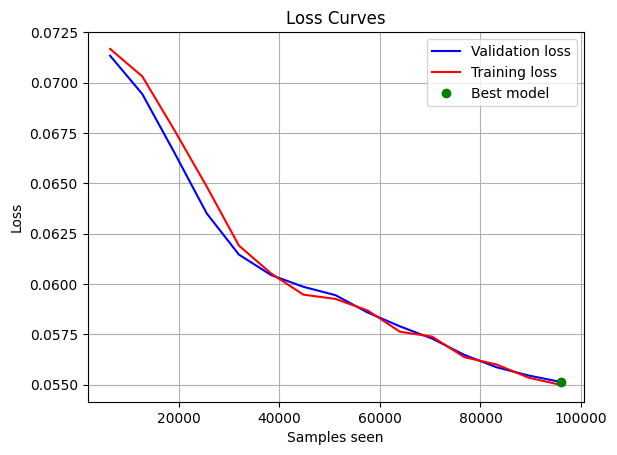

In [8]:
plt.clf()
plt.xlabel('Samples seen')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.plot(nb_sample_array, val_err_array, 'b', label='Validation loss')
plt.plot(nb_sample_array, train_err_array, 'r', label='Training loss')
plt.plot([best_nb_sample], [best_val_loss], 'go', label='Best model')
plt.legend()
plt.grid(True)
plt.show()

## Test the network on the test data

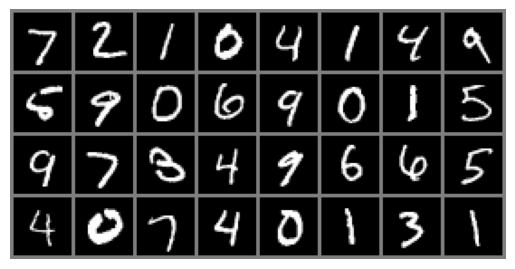

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1
Predicted  :      7     2     1     0     4     1     4     4     6     7     0     6     4     0     1     3     4     7     6     4     7     6     6     8     4     0     7     4     0     1     3     1


In [9]:
# First on few sample, just to see real results
dataiter = iter(testloader)
images_cpu, labels_cpu = next(dataiter)
images, labels = images_cpu.to(device), labels_cpu.to(device)
plt.clf()
displayDataAsImage(torchvision.utils.make_grid(images_cpu))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(minibatchsize)))

# Activate the net with these examples
outputs = best_model(images)

# Get the maximum class number for each sample, but print the corresponding class name
_, predicted = torch.max(outputs, 1)
print('Predicted  : ', ' '.join('%5s' % classes[predicted[j]] for j in range(minibatchsize)))

In [10]:
# Test now  on the whole test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %3.2f %%' % (100.0 * correct / total))
accuracy = 100.0 * correct / total
error_rate = 100.0 - accuracy
print("Error rate of the network on the test images: %.2f %%" % error_rate)

Accuracy of the network on the test images: 74.21 %
Error rate of the network on the test images: 25.79 %


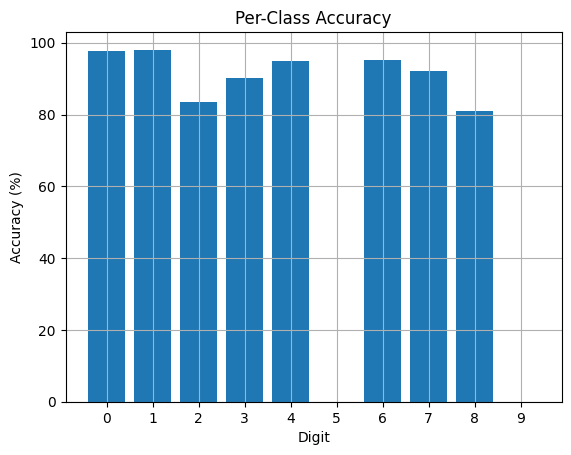

Accuracy of     0 : 97.65 % (957/980)
Accuracy of     1 : 98.06 % (1113/1135)
Accuracy of     2 : 83.43 % (861/1032)
Accuracy of     3 : 90.10 % (910/1010)
Accuracy of     4 : 95.01 % (933/982)
Accuracy of     5 : 0.00 % (0/892)
Accuracy of     6 : 95.09 % (911/958)
Accuracy of     7 : 92.22 % (948/1028)
Accuracy of     8 : 80.90 % (788/974)
Accuracy of     9 : 0.00 % (0/1009)


In [11]:
import matplotlib.pyplot as plt

# Check the results for each class
class_correct = list(0. for i in range(nb_classes))
class_total = list(0. for i in range(nb_classes))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Compute ... and show results
plt.bar([str(c) for c in classes], [100 * class_correct[i] / class_total[i] for i in range(nb_classes)])
plt.ylabel('Accuracy (%)')
plt.xlabel('Digit')
plt.title('Per-Class Accuracy')
plt.grid(True)
plt.show()
for i in range(nb_classes):
    if class_total[i] > 0 :
        print('Accuracy of %5s : %3.2f %% (%d/%d)' % (
            classes[i], 100.0 * class_correct[i] / class_total[i], class_correct[i] , class_total[i]))
    else:
        print('No %5s sample' % (classes[i]))

## Answer here Q2 (functional training).

In [12]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def loader_train_mnist(minibatchsize, trainset_size, validation_size):
    """
    Load the MNIST dataset and return the train and validation loaders and the train and validation set.
    """
    transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    fulltrainset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)

    trainset, validationset, _ignored_part = torch.utils.data.random_split(fulltrainset, [trainset_size, validation_size, (60000 - trainset_size - validation_size)])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatchsize, shuffle=True, num_workers=0)
    validationloader = torch.utils.data.DataLoader(validationset, batch_size=minibatchsize, shuffle=False, num_workers=0)

    return trainloader, validationloader, trainset, validationset

def loader_test_mnist(minibatchsize):
    """
    Load the MNIST test dataset and return the test loader and test set .
    """
    transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # Load the test set:
    testset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=minibatchsize, shuffle=False, num_workers=0)

    return testloader, testset

def train_model(model, minibatchsize, trainset_size, validation_size,
                num_epochs=5,
                val_check_batch_interval =200,
                criterion=nn.CrossEntropyLoss(),
                optimizer_fn=lambda params: optim.SGD(params, lr=0.001, momentum=0.9),
                device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    """
    Train the model using the specified parameters.
    """
    model.to(device)
    optimizer = optimizer_fn(model.parameters())

    trainloader, validationloader, trainset, validationset = loader_train_mnist(minibatchsize=minibatchsize, trainset_size=trainset_size, validation_size=validation_size)
    
    val_err_array = np.array([])
    train_err_array = np.array([])
    nb_sample_array = np.array([])

    best_val_loss = 1000000
    best_nb_sample = 0
    best_model = copy.deepcopy(model)

    nb_used_sample = 0
    running_loss = 0.0

    print('---- Training parameters --')
    print(f'Train set size : {trainset_size} | Validation set size : {validation_size}')
    print(f'Device : {device} | Batch size : {minibatchsize} | Epochs : {num_epochs} | Validation check batch interval : {val_check_batch_interval}')
    print('---- Model parameters -----')
    print(f'Optimizer : {optimizer.__class__.__name__} | Loss function : {criterion.__class__.__name__}')
    print('---- Training process -----')
    print(f'Start training the model...')
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            nb_used_sample += minibatchsize
            running_loss += loss.item()

            if nb_used_sample % (val_check_batch_interval  * minibatchsize) == 0:
                train_err = (running_loss / (val_check_batch_interval  * minibatchsize))
                running_loss = 0.0

                total_val_loss = 0.0
                with torch.no_grad():
                    for val_data in validationloader:
                        val_images, val_labels = val_data
                        val_images, val_labels = val_images.to(device), val_labels.to(device)
                        val_outputs = model(val_images)
                        val_loss = criterion(val_outputs, val_labels)
                        total_val_loss += val_loss.item()
                val_err = (total_val_loss / len(validationset))

                train_err_array = np.append(train_err_array, train_err)
                val_err_array = np.append(val_err_array, val_err)
                nb_sample_array = np.append(nb_sample_array, nb_used_sample)

                if val_err < best_val_loss:
                    best_val_loss = val_err
                    best_nb_sample = nb_used_sample
                    best_model = copy.deepcopy(model)

        print(f'Epoch {epoch+1}/{num_epochs} took {time.time() - start_time:.2f}s - Train loss: {train_err:.3f} - Validation loss: {val_err:.3f}')
        print(f'Best validation loss: {best_val_loss:.4f} at {best_nb_sample} samples')

    print('Training complete!')
    return best_model, nb_sample_array, train_err_array, val_err_array, best_val_loss, best_nb_sample

def draw_loss_curves(nb_sample_array, train_err_array, val_err_array, best_nb_sample, best_val_loss):
    """
    Draw the loss curves for training and validation losses.
    """

    plt.clf()
    plt.xlabel('Samples seen')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.plot(nb_sample_array, val_err_array, 'b', label='Validation loss')
    plt.plot(nb_sample_array, train_err_array, 'r', label='Training loss')
    plt.plot([best_nb_sample], [best_val_loss], 'go', label='Best model')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(model, minibatchsize, device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    """
    Evaluate the model on the test set and print the accuracy.
    """
    model.to(device)
    correct = 0
    total = 0

    testloader, testset = loader_test_mnist(minibatchsize=minibatchsize)

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f'Accuracy of the network on the test images is : {accuracy:.2f}%')
    return accuracy

def count_trainable_parameters(model):
    """
    Count the number of trainable parameters in the model.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params:,}')

---- Training parameters --
Train set size : 20000 | Validation set size : 10000
Device : cuda:0 | Batch size : 32 | Epochs : 5 | Validation check batch interval : 200
---- Model parameters -----
Optimizer : SGD | Loss function : CrossEntropyLoss
---- Training process -----
Start training the model...
Epoch 1/5 took 14.09s - Train loss: 0.068 - Validation loss: 0.067
Best validation loss: 0.0666 at 19200 samples
Epoch 2/5 took 12.89s - Train loss: 0.060 - Validation loss: 0.059
Best validation loss: 0.0594 at 38400 samples
Epoch 3/5 took 12.60s - Train loss: 0.058 - Validation loss: 0.057
Best validation loss: 0.0573 at 57600 samples
Epoch 4/5 took 12.28s - Train loss: 0.057 - Validation loss: 0.057
Best validation loss: 0.0568 at 76800 samples
Epoch 5/5 took 14.06s - Train loss: 0.055 - Validation loss: 0.055
Best validation loss: 0.0550 at 96000 samples
Training complete!
Accuracy of the network on the test images is : 75.17%


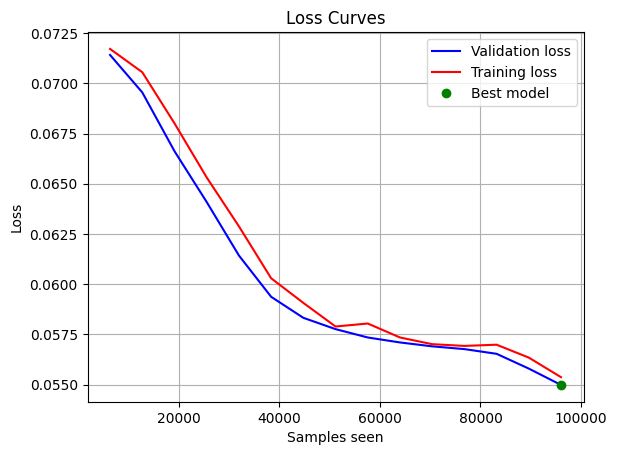

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class NetMLP(nn.Module):
    def __init__(self, hiddencells = 100):
        super(NetMLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 , hiddencells)
        self.fc2 = nn.Linear(hiddencells, 10)
    
    def forward(self, x):
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

minibatchsize = 32
best_model, nb_sample_array, train_err_array, val_err_array, best_val_loss, best_nb_sample = train_model(NetMLP(100), 
                                                                                                         minibatchsize=minibatchsize, 
                                                                                                         trainset_size=20000, 
                                                                                                         validation_size=10000)
evaluate_model(best_model, minibatchsize=minibatchsize)
draw_loss_curves(nb_sample_array, train_err_array, val_err_array, best_nb_sample, best_val_loss)

## Answer here Q3 (number of weights)

In [14]:
count_trainable_parameters(best_model)

Total trainable parameters: 103,510


## Answer here Q4 (overfitting MNIST).

---- Training parameters --
Train set size : 50 | Validation set size : 1000
Device : cuda:0 | Batch size : 2 | Epochs : 100 | Validation check batch interval : 5
---- Model parameters -----
Optimizer : SGD | Loss function : CrossEntropyLoss
---- Training process -----
Start training the model...
Epoch 1/100 took 3.84s - Train loss: 1.088 - Validation loss: 1.146
Best validation loss: 1.1453 at 40 samples
Epoch 2/100 took 3.52s - Train loss: 1.079 - Validation loss: 1.146
Best validation loss: 1.1453 at 40 samples
Epoch 3/100 took 4.16s - Train loss: 1.067 - Validation loss: 1.157
Best validation loss: 1.1358 at 110 samples
Epoch 4/100 took 3.88s - Train loss: 0.978 - Validation loss: 1.148
Best validation loss: 1.1290 at 190 samples
Epoch 5/100 took 3.62s - Train loss: 1.053 - Validation loss: 1.107
Best validation loss: 1.1068 at 250 samples
Epoch 6/100 took 3.41s - Train loss: 1.037 - Validation loss: 1.076
Best validation loss: 1.0763 at 300 samples
Epoch 7/100 took 3.45s - Train l

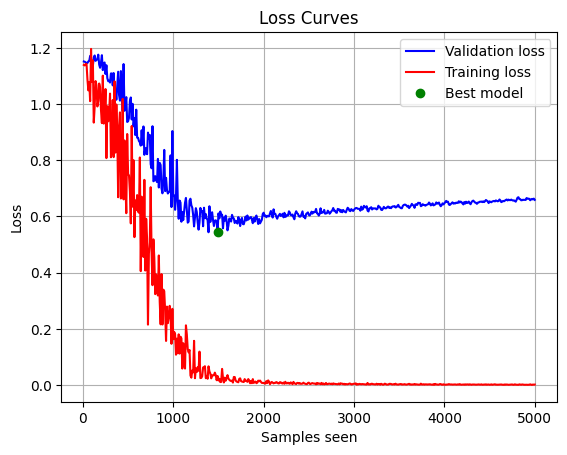

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class OverkillMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

minibatchsize = 2
best_model, nb_sample_array, train_err_array, val_err_array, best_val_loss, best_nb_sample = train_model(OverkillMLP(), 
                                                                                                         minibatchsize=minibatchsize, 
                                                                                                         trainset_size=50, 
                                                                                                         validation_size=1000, 
                                                                                                         val_check_batch_interval=5,
                                                                                                         num_epochs=100,
                                                                                                         criterion=nn.CrossEntropyLoss(),
                                                                                                         optimizer_fn=lambda params: optim.SGD(params, lr=0.01))
evaluate_model(best_model, minibatchsize=minibatchsize)
draw_loss_curves(nb_sample_array, train_err_array, val_err_array, best_nb_sample, best_val_loss)